# Race Detection

## Data Loading

In [1]:
import pandas as pd
import cv2
# import warnings
# warnings.filterwarnings('always')

In [3]:
Data_dir = "gray-images"
split = 0.7
w_img = h_img = 198
Gender = {0: 'male', 1: 'female'}
Gender_map = dict((g, i) for i, g in Gender.items())
Race = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
Race_map = dict((r, i) for i, r in Race.items())

Gender, Gender_map, Race, Race_map

({0: 'male', 1: 'female'},
 {'male': 0, 'female': 1},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4})

In [3]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), Gender[int(gender)], Race[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

In [4]:
import glob
import os

In [5]:
files = glob.glob(os.path.join(Data_dir, "*.jpg"))

In [6]:
attributes = list(map(parse_filepath, files))

In [7]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df.head()

,age,gender,race,file
0,10,male,white,gray-images\10_0_0_20161220222308131.jpg.chip.jpg
1,10,male,white,gray-images\10_0_0_20170103200329407.jpg.chip.jpg
2,10,male,white,gray-images\10_0_0_20170103200522151.jpg.chip.jpg
3,10,male,white,gray-images\10_0_0_20170103233459275.jpg.chip.jpg
4,10,male,white,gray-images\10_0_0_20170104013211746.jpg.chip.jpg


In [8]:
df

,age,gender,race,file
0,10,male,white,gray-images\10_0_0_20161220222308131.jpg.chip.jpg
1,10,male,white,gray-images\10_0_0_20170103200329407.jpg.chip.jpg
2,10,male,white,gray-images\10_0_0_20170103200522151.jpg.chip.jpg
3,10,male,white,gray-images\10_0_0_20170103233459275.jpg.chip.jpg
4,10,male,white,gray-images\10_0_0_20170104013211746.jpg.chip.jpg
...,...,...,...,...
10534,9,female,indian,gray-images\9_1_3_20161220222856346.jpg
10535,9,female,indian,gray-images\9_1_3_20170104222949455.jpg
10536,9,female,others,gray-images\9_1_4_20170103200637399.jpg
10537,9,female,others,gray-images\9_1_4_20170103200814791.jpg


In [9]:
df.describe()

,age
count,10539.000000
mean,40.850081
std,18.248353
min,7.000000
25%,26.000000
50%,43.000000
75%,55.000000
max,75.000000


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

## Data Exploration & Visualization

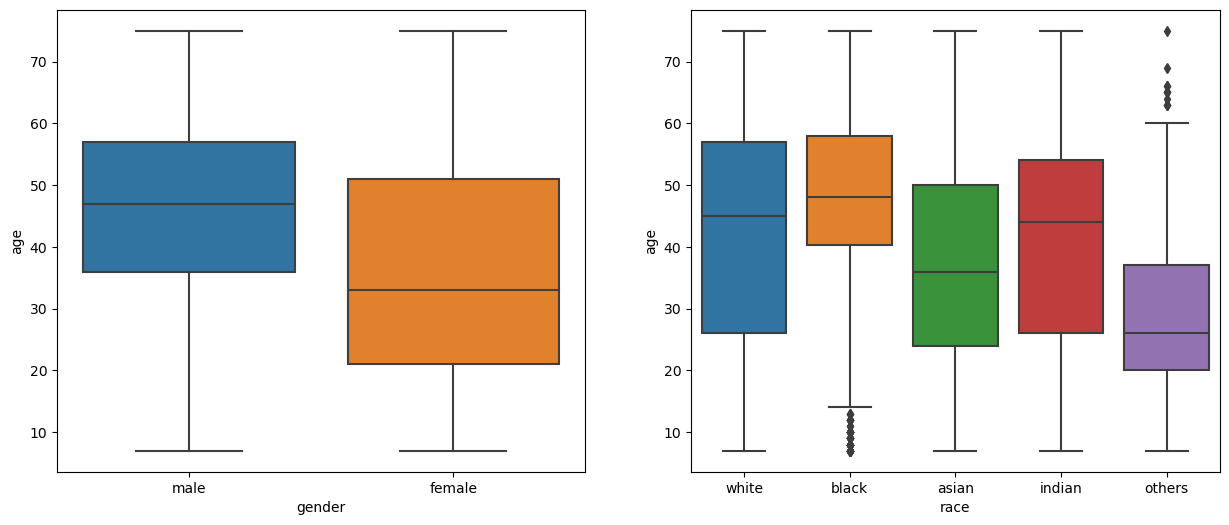

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

<AxesSubplot:xlabel='gender', ylabel='age'>

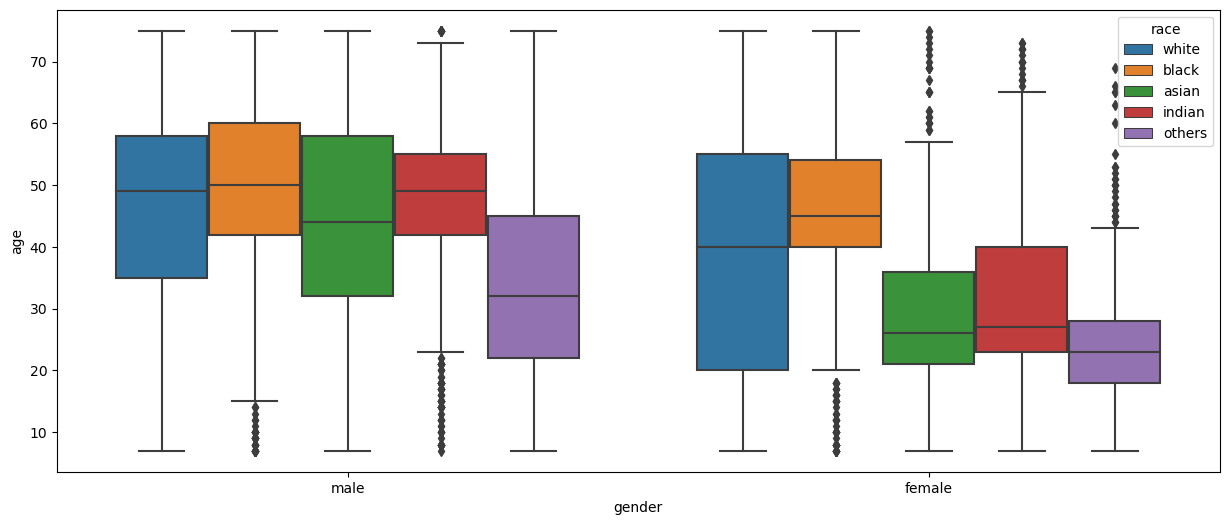

In [12]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='gender', y='age', hue='race')

<AxesSubplot:xlabel='race,gender'>

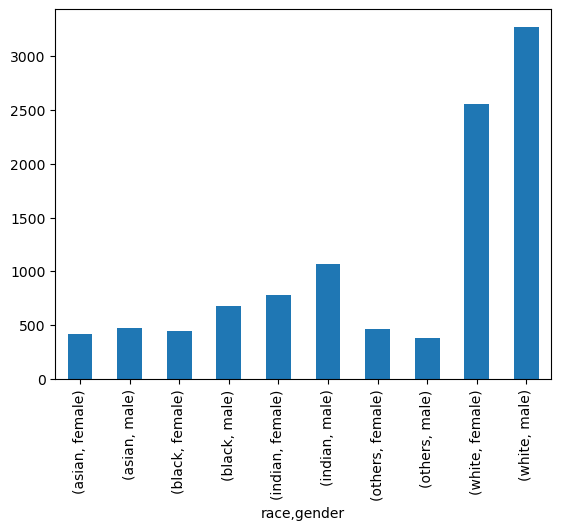

In [13]:
df.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')

<AxesSubplot:>

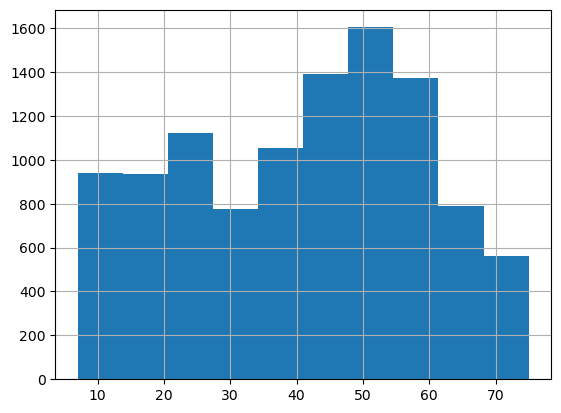

In [14]:
df['age'].hist()

In [15]:
df['age'].describe()

count    10539.000000
mean        40.850081
std         18.248353
min          7.000000
25%         26.000000
50%         43.000000
75%         55.000000
max         75.000000
Name: age, dtype: float64

In [16]:
# df = df[(df['age'] > 10) & (df['age'] < 65)]

## Data Preprocessing

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split

In [18]:
# perm = np.random.permutation(len(df))
# train_len = int(len(df) * 0.85)
# train = perm[:train_len]
# test = perm[train_len:]

# # print(train)
# train_len = int(train_len * 0.8235)
# train, val = train[:train_len], train[train_len:]

train, test = train_test_split(df, test_size=(1 - split))
test, val = train_test_split(test, test_size=0.5)

df['gender_id'] = df['gender'].map(lambda gender: Gender_map[gender])
df['race_id'] = df['race'].map(lambda race: Race_map[race])

max_age = df['age'].max()

In [19]:
train = train.index.to_list()
test = test.index.to_list()
val = val.index.to_list()
print(len(train), len(val), len(test))

7377 1581 1581


In [20]:
print(max_age)
df

75


,age,gender,race,file,gender_id,race_id
0,10,male,white,gray-images\10_0_0_20161220222308131.jpg.chip.jpg,0,0
1,10,male,white,gray-images\10_0_0_20170103200329407.jpg.chip.jpg,0,0
2,10,male,white,gray-images\10_0_0_20170103200522151.jpg.chip.jpg,0,0
3,10,male,white,gray-images\10_0_0_20170103233459275.jpg.chip.jpg,0,0
4,10,male,white,gray-images\10_0_0_20170104013211746.jpg.chip.jpg,0,0
...,...,...,...,...,...,...
10534,9,female,indian,gray-images\9_1_3_20161220222856346.jpg,1,3
10535,9,female,indian,gray-images\9_1_3_20170104222949455.jpg,1,3
10536,9,female,others,gray-images\9_1_4_20170103200637399.jpg,1,4
10537,9,female,others,gray-images\9_1_4_20170103200814791.jpg,1,4


In [21]:
from keras.utils import to_categorical
from PIL import Image

In [22]:
# train

In [23]:
def data_gen(df, indices, training, batch_sz):
    images = []
    races = []
    genders = []
    ages = []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            image = Image.open(file)
            image = image.resize((w_img, h_img))
            image = np.array(image)/255
            images.append(image)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(Race_map)))
            genders.append(to_categorical(gender, 2))
            if len(images)>=batch_sz:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
#                 print(np.shape(images), np.shape(ages), np.shape(races), np.shape(genders))
                images = []
                races = []
                genders = []
                ages = []
        if not training:
            break

## Model

In [24]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from keras.optimizers import Adam
from keras.models import Model
import warnings
warnings.filterwarnings('always')

In [1]:
print(len(Race_map), len(Gender_map))

NameError: name 'Race_map' is not defined

In [ ]:
from keras import regularizers

In [27]:
input_1 = Input(shape=(h_img, w_img, 1))
conv_1 = Conv2D(filters=32, kernel_size=3, activation='relu')(input_1)
conv_1 = BatchNormalization()(conv_1)
conv_1 = MaxPool2D()(conv_1)
conv_1 = Dropout(0.2)(conv_1)

conv_2 = Conv2D(filters=64, kernel_size=3, activation='relu')(conv_1)
conv_2 = BatchNormalization()(conv_2)
conv_2 = MaxPool2D()(conv_2)
conv_2 = Dropout(0.3)(conv_2)

conv_3 = Conv2D(filters=96, kernel_size=3, activation='relu')(conv_2)
conv_3 = BatchNormalization()(conv_3)
conv_3 = MaxPool2D()(conv_3)
conv_3 = Dropout(0.3)(conv_3)

gmax = GlobalMaxPool2D()(conv_3)

# Age
age = Dense(units=128, activation='relu')(gmax)
age = Dropout(0.3)(age)
age = Dense(units=1, activation='sigmoid', name='age-output')(age)

conv_4 = Conv2D(filters=128, kernel_size=3, activation='relu')(conv_3)
conv_4 = BatchNormalization()(conv_4)
conv_4 = MaxPool2D()(conv_4)
conv_4 = Dropout(0.4)(conv_4)

gmax_gender = GlobalMaxPool2D()(conv_4)

# Gender
gender = Dense(units=128, activation='relu')(gmax_gender)
gender = Dropout(0.3)(gender)
gender = Dense(units=len(Gender_map), activation='softmax', name='gender-output')(gender)

# conv_5 = Conv2D(filters=160, kernel_size=3, activation='relu')(conv_4)
# conv_5 = BatchNormalization()(conv_5)
# conv_5 = MaxPool2D()(conv_5)
# conv_5 = Dropout(0.3)(conv_5)

# gmax_race = GlobalMaxPool2D()(conv_5)

# Race
race = Dense(units=160, activation='relu')(gmax_gender)
race = Dropout(0.4)(race)
race = Dense(units=128, activation='relu')(race)
race = Dense(units=len(Race_map), activation='softmax', name='race-output')(race)

model = Model(inputs=input_1, outputs=[age, race, gender])
model.compile(optimizer='adam',loss={'age-output': 'mse', 'race-output': 'categorical_crossentropy', 
                                     'gender-output': 'categorical_crossentropy'},
             loss_weights={'age-output': 2., 'race-output': 1.5, 'gender-output': 1.},
             metrics={'age-output': 'mae', 'race-output': 'accuracy', 'gender-output': 'accuracy'})
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 198, 198, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 196, 196, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 196, 196, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [28]:
from keras.callbacks import ModelCheckpoint

batch_size = 96
valid_batch_size = 96

train_gen = data_gen(df, train, training=True, batch_sz=batch_size)
valid_gen = data_gen(df, val, training=True, batch_sz=valid_batch_size)

In [29]:
# callbacks = [
#     ModelCheckpoint("./model_checkpoint", monitor='val_loss')
# ]

history = model.fit(train_gen,
                    steps_per_epoch=len(train)//batch_size,
                    epochs=100,
#                     callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(val)//valid_batch_size)

Epoch 1/100
76/76 [==============================] - 17s 161ms/step - loss: 4.0698 - age-output_loss: 0.2356 - race-output_loss: 1.5693 - gender-output_loss: 1.2445 - age-output_mae: 0.4175 - race-output_accuracy: 0.5032 - gender-output_accuracy: 0.5622 - val_loss: 3.0431 - val_age-output_loss: 0.0601 - val_race-output_loss: 1.3617 - val_gender-output_loss: 0.8805 - val_age-output_mae: 0.2061 - val_race-output_accuracy: 0.5449 - val_gender-output_accuracy: 0.4473
Epoch 2/100
76/76 [==============================] - 13s 169ms/step - loss: 2.8192 - age-output_loss: 0.1532 - race-output_loss: 1.2412 - gender-output_loss: 0.6509 - age-output_mae: 0.3198 - race-output_accuracy: 0.5583 - gender-output_accuracy: 0.6320 - val_loss: 2.9826 - val_age-output_loss: 0.0717 - val_race-output_loss: 1.3239 - val_gender-output_loss: 0.8533 - val_age-output_mae: 0.2170 - val_race-output_accuracy: 0.5469 - val_gender-output_accuracy: 0.4460
Epoch 3/100
76/76 [==============================] - 15s 192ms/s

76/76 [==============================] - 12s 158ms/step - loss: 1.5340 - age-output_loss: 0.0322 - race-output_loss: 0.7787 - gender-output_loss: 0.3016 - age-output_mae: 0.1356 - race-output_accuracy: 0.7112 - gender-output_accuracy: 0.8724 - val_loss: 1.8094 - val_age-output_loss: 0.0396 - val_race-output_loss: 0.9238 - val_gender-output_loss: 0.3445 - val_age-output_mae: 0.1566 - val_race-output_accuracy: 0.6986 - val_gender-output_accuracy: 0.8457
Epoch 36/100
76/76 [==============================] - 12s 158ms/step - loss: 1.5115 - age-output_loss: 0.0315 - race-output_loss: 0.7698 - gender-output_loss: 0.2937 - age-output_mae: 0.1347 - race-output_accuracy: 0.7170 - gender-output_accuracy: 0.8797 - val_loss: 1.8618 - val_age-output_loss: 0.0489 - val_race-output_loss: 0.9595 - val_gender-output_loss: 0.3247 - val_age-output_mae: 0.1759 - val_race-output_accuracy: 0.6309 - val_gender-output_accuracy: 0.8802
Epoch 37/100
76/76 [==============================] - 12s 158ms/step - loss

76/76 [==============================] - 14s 190ms/step - loss: 1.1807 - age-output_loss: 0.0288 - race-output_loss: 0.6002 - gender-output_loss: 0.2229 - age-output_mae: 0.1281 - race-output_accuracy: 0.7800 - gender-output_accuracy: 0.9076 - val_loss: 1.5633 - val_age-output_loss: 0.0422 - val_race-output_loss: 0.7937 - val_gender-output_loss: 0.2884 - val_age-output_mae: 0.1625 - val_race-output_accuracy: 0.7409 - val_gender-output_accuracy: 0.8613
Epoch 70/100
76/76 [==============================] - 12s 158ms/step - loss: 1.1535 - age-output_loss: 0.0284 - race-output_loss: 0.5873 - gender-output_loss: 0.2157 - age-output_mae: 0.1281 - race-output_accuracy: 0.7833 - gender-output_accuracy: 0.9131 - val_loss: 1.5408 - val_age-output_loss: 0.0302 - val_race-output_loss: 0.7901 - val_gender-output_loss: 0.2953 - val_age-output_mae: 0.1328 - val_race-output_accuracy: 0.7350 - val_gender-output_accuracy: 0.8672
Epoch 71/100
76/76 [==============================] - 12s 163ms/step - loss

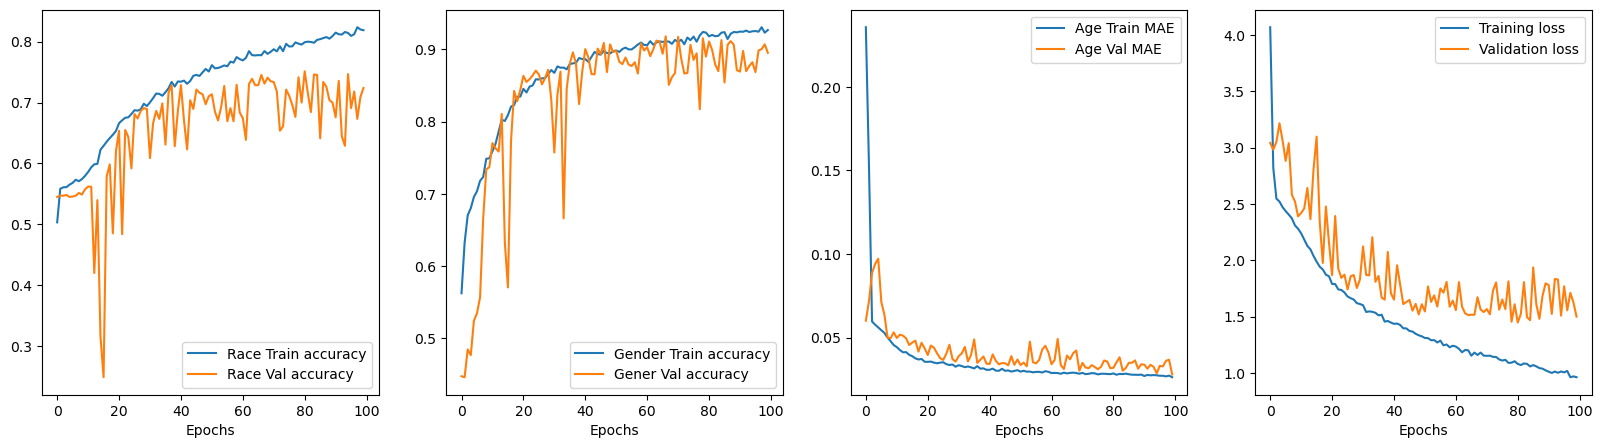

In [30]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].plot(history.history['race-output_accuracy'], label='Race Train accuracy')
axes[0].plot(history.history['val_race-output_accuracy'], label='Race Val accuracy')
axes[0].set_xlabel('Epochs')
axes[0].legend()

axes[1].plot(history.history['gender-output_accuracy'], label='Gender Train accuracy')
axes[1].plot(history.history['val_gender-output_accuracy'], label='Gener Val accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend()

axes[2].plot(history.history['age-output_loss'], label='Age Train MAE')
axes[2].plot(history.history['val_age-output_loss'], label='Age Val MAE')
axes[2].set_xlabel('Epochs')
axes[2].legend()  

axes[3].plot(history.history['loss'], label='Training loss')
axes[3].plot(history.history['val_loss'], label='Validation loss')
axes[3].set_xlabel('Epochs')
axes[3].legend()

In [31]:
test_gen = data_gen(df, test, training=False, batch_sz=128)
dict(zip(model.metrics_names, model.evaluate(test_gen, steps=len(test)//128)))

12/12 [==============================] - 2s 152ms/step - loss: 1.5023 - age-output_loss: 0.0304 - race-output_loss: 0.7899 - gender-output_loss: 0.2566 - age-output_mae: 0.1335 - race-output_accuracy: 0.7266 - gender-output_accuracy: 0.8867


{'loss': 1.5023061037063599,
 'age-output_loss': 0.03041493333876133,
 'race-output_loss': 0.7898945212364197,
 'gender-output_loss': 0.256634384393692,
 'age-output_mae': 0.1335170418024063,
 'race-output_accuracy': 0.7265625,
 'gender-output_accuracy': 0.88671875}

In [32]:
test_gen = data_gen(df, test, training=False, batch_sz=128)
x_test, (age_true, race_true, gender_true)= next(test_gen)
age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)

In [33]:
race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)
age_true = age_true * max_age
age_pred = age_pred * max_age

In [34]:
from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred, zero_division=1))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred, zero_division=1))

Classification report for race
              precision    recall  f1-score   support

           0       0.86      0.97      0.91        74
           1       0.75      0.46      0.57        13
           2       0.83      0.56      0.67         9
           3       0.74      0.74      0.74        23
           4       0.29      0.22      0.25         9

    accuracy                           0.80       128
   macro avg       0.69      0.59      0.63       128
weighted avg       0.78      0.80      0.78       128


Classification report for gender
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        75
           1       0.78      0.89      0.83        53

    accuracy                           0.85       128
   macro avg       0.85      0.86      0.85       128
weighted avg       0.86      0.85      0.85       128



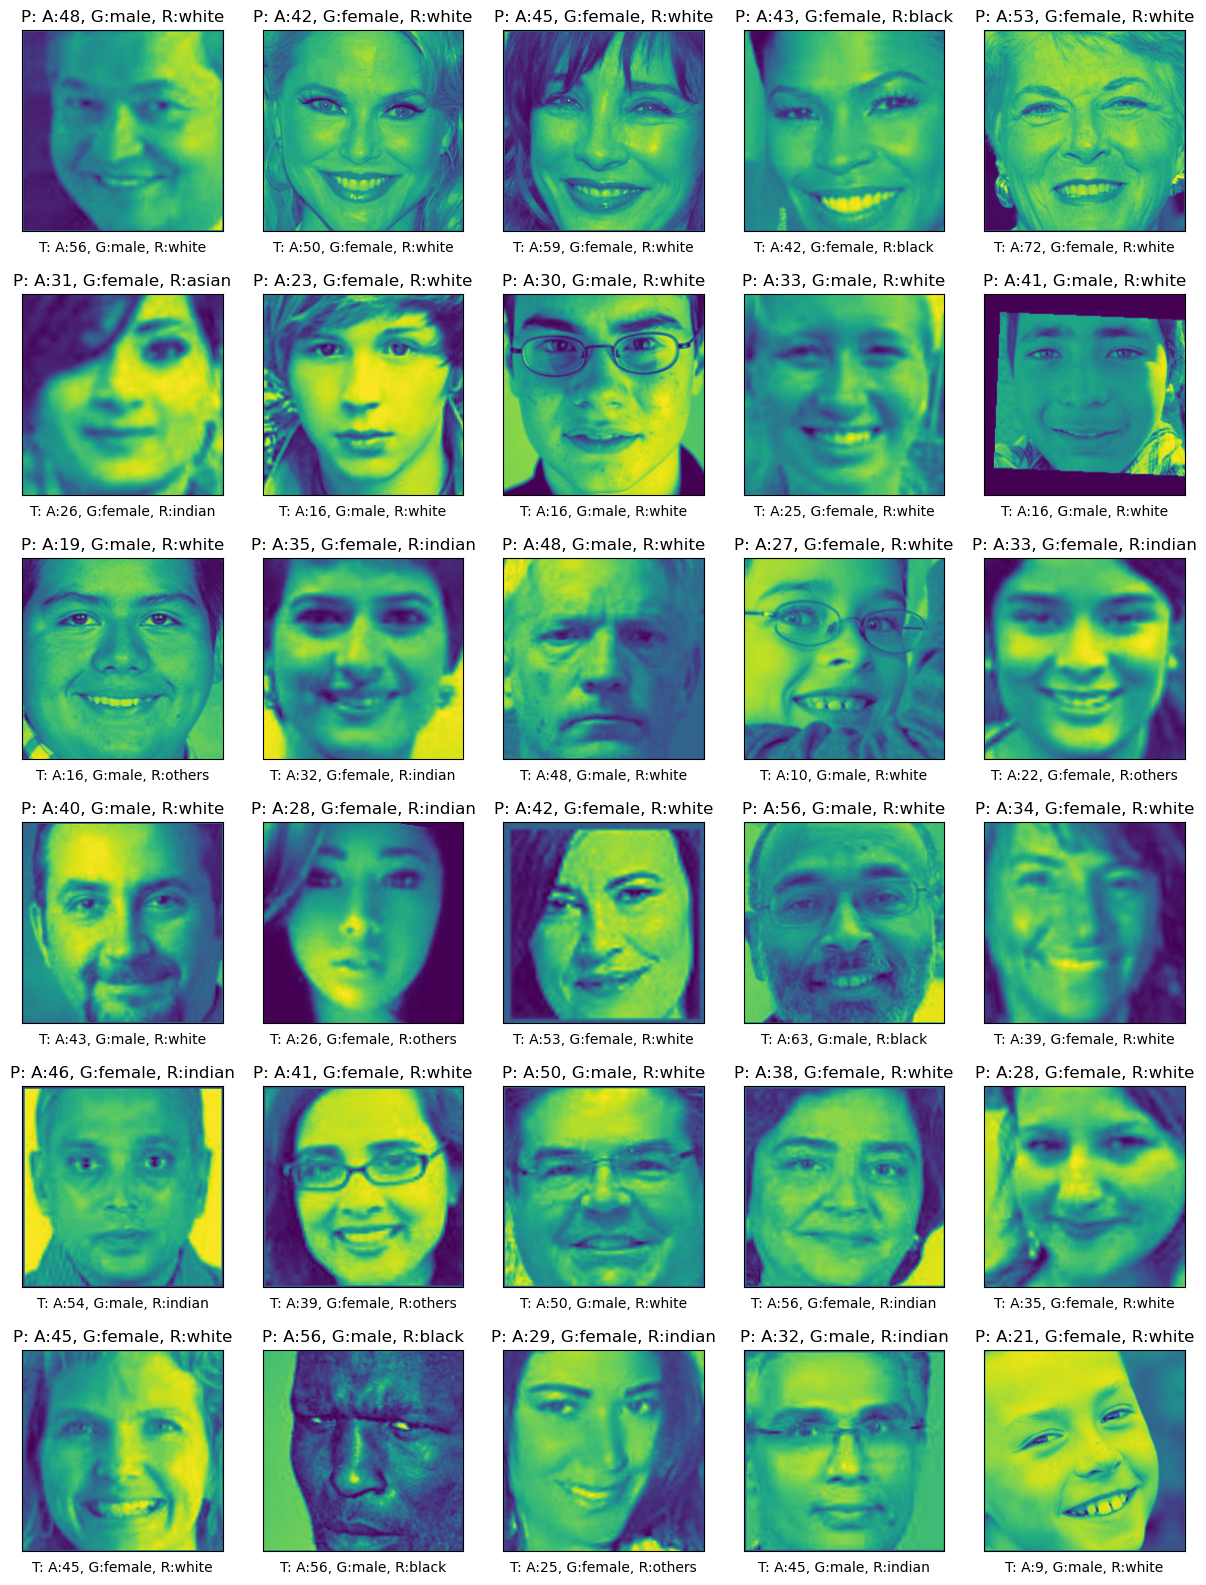

In [35]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('P: A:{}, G:{}, R:{}'.format(int(age_pred[img_idx]), Gender[gender_pred[img_idx]], Race[race_pred[img_idx]]))
    ax.set_xlabel('T: A:{}, G:{}, R:{}'.format(int(age_true[img_idx]), Gender[gender_true[img_idx]], Race[race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])

## Model Save

In [36]:
model.save("model_1.h5")

In [7]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def preprocess_image(img_path):
    # Load the image
    img = image.load_img(img_path, color_mode="grayscale", target_size=(h_img, w_img))
    
    # Convert the image to numpy array
    
    img_array = image.img_to_array(img)
    
    # Normalize the image
    img_array = img_array / 255.0
    
    # Expand the dimensions of the image
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

# Load the model
model = load_model("model_1.h5")

1/1 [==============================] - 0s 110ms/step


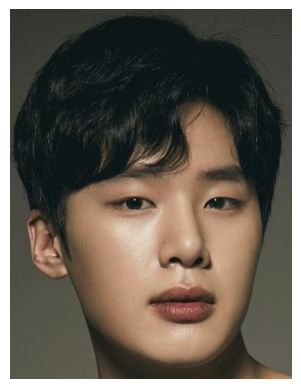

Age: 25.78940838575363
Race: Asian
Gender: Male


In [8]:
img = "asian-male.jpg"

# Preprocess the input image
img_array = preprocess_image(img)

# Make predictions
preds = model.predict(img_array)

# Extract predictions
age = preds[0][0][0]

race_labels = ['White', 'Black', 'Asian', 'Indian', 'Others']
race = race_labels[np.argmax(preds[1][0])]

gender_labels = ['Male', 'Female']
gender = gender_labels[np.argmax(preds[2][0])]

# Image Display
img = mpimg.imread(img)
plt.imshow(img)
plt.axis('off')
plt.show()

# Print the age, race and gender
print("Age:", age*75)
print("Race:", race)
print("Gender:", gender)